In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1 Cross-correlation of the cued and uncued tags

### 1.1 Pre-post on cued

In [108]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','prepost']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued']
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-display', 'post': 'Post-display'})



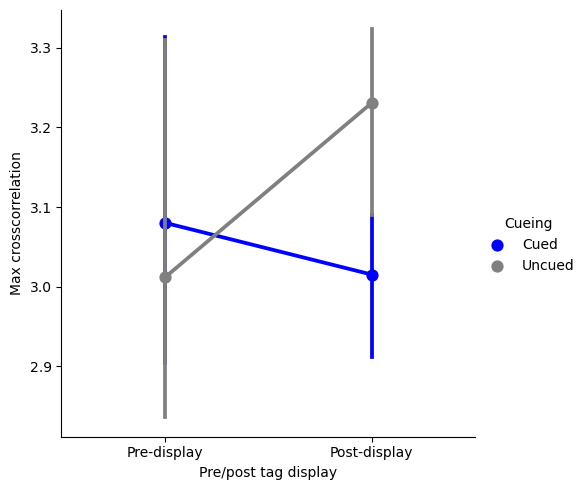

In [109]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display', hue='Cueing', data=crosscorr, kind='point', order=['Pre-display','Post-display'], palette=['blue','grey'])

In [110]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued prepost     value  Max crosscorrelation  Cueing  \
0           A0    1       1  3.090493              3.090493    Cued   
1           A0    1       0  2.903955              2.903955    Cued   
2           A0    0       1  3.089554              3.089554  Uncued   
3           A0    0       0  2.836120              2.836120  Uncued   
4           A1    1       1  3.043976              3.043976    Cued   
5           A1    1       0  3.023019              3.023019    Cued   
6           A1    0       1  3.280434              3.280434  Uncued   
7           A1    0       0  3.309926              3.309926  Uncued   
8           A2    1       1  2.911419              2.911419    Cued   
9           A2    1       0  3.314114              3.314114    Cued   
10          A2    0       1  3.323133              3.323133  Uncued   
11          A2    0       0  2.889137              2.889137  Uncued   

   Pre/post tag display  
0          Post-display  
1           Pre-display 

In [111]:
md = smf.mixedlm("value ~ cued * prepost", crosscorr, groups=crosscorr["participant"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     12          Method:                 REML   
No. Groups:           3           Scale:                  0.0334 
Min. group size:      4           Log-Likelihood:         -0.0219
Max. group size:      4           Converged:              Yes    
Mean group size:      4.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.012    0.106 28.288 0.000  2.803  3.220
cued[T.1]               0.069    0.149  0.460 0.646 -0.224  0.361
prepost[T.1]            0.219    0.149  1.470 0.142 -0.073  0.512
cued[T.1]:prepost[T.1] -0.284    0.211 -1.348 0.178 -0.698  0.129
Group Var               0.001    0.057                           



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### 1.2 Comparing same vs other trials

In [112]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_cueduncued.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','trial_type']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Tags from same trials', 'other': 'Tags from other trials'})



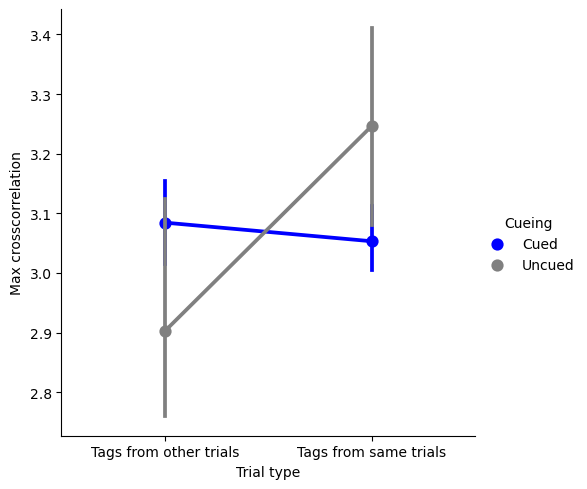

In [113]:
sns.catplot(y='Max crosscorrelation', x='Trial type', hue='Cueing', data=crosscorr, kind='point', units='participant', palette=['blue','grey'], aspect=1)

In [114]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued trial_type     value  Max crosscorrelation  Cueing  \
0           A0    1          1  2.945446              2.945446    Cued   
1           A0    1          0  3.004530              3.004530    Cued   
2           A0    0          1  2.759659              2.759659  Uncued   
3           A0    0          0  3.080123              3.080123  Uncued   
4           A1    1          1  3.153704              3.153704    Cued   
5           A1    1          0  3.112719              3.112719    Cued   
6           A1    0          1  3.123408              3.123408  Uncued   
7           A1    0          0  3.249841              3.249841  Uncued   
8           A2    1          1  3.154264              3.154264    Cued   
9           A2    1          0  3.042401              3.042401    Cued   
10          A2    0          1  2.824691              2.824691  Uncued   
11          A2    0          0  3.410172              3.410172  Uncued   

                Trial type  
0   Tags

In [115]:
md = smf.mixedlm("value ~ cued * trial_type", crosscorr, groups=crosscorr["participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value 
No. Observations:       12           Method:                  REML  
No. Groups:             3            Scale:                   0.0111
Min. group size:        4            Log-Likelihood:          2.9670
Max. group size:        4            Converged:               Yes   
Mean group size:        4.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  3.247    0.083 39.185 0.000  3.084  3.409
cued[T.1]                 -0.193    0.086 -2.249 0.025 -0.362 -0.025
trial_type[T.1]           -0.344    0.086 -3.999 0.000 -0.513 -0.175
cued[T.1]:trial_type[T.1]  0.375    0.122  3.085 0.002  0.137  0.614
Group Var                  0.009    0.134         

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 2 Cross-correlation of the averaged tags 

### 2.1 Pre-post on averaged

In [116]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost_avgtag.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr = crosscorr.groupby(['prepost', 'participant'])['value'].mean().reset_index()
crosscorr['Max crosscorrelation'] = crosscorr['value']
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-display', 'post': 'Post-display'})


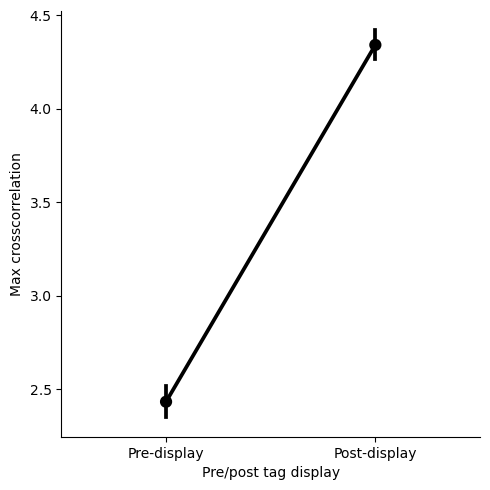

In [117]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display',  data=crosscorr, kind='point', order=['Pre-display','Post-display'], color='black')

In [118]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
print(crosscorr)

  prepost participant     value  Max crosscorrelation Pre/post tag display
0       1          A0  4.264108              4.264108         Post-display
1       1          A2  4.419394              4.419394         Post-display
2       0          A0  2.516466              2.516466          Pre-display
3       0          A2  2.349013              2.349013          Pre-display


In [119]:
md = smf.mixedlm("value ~ prepost", crosscorr, groups=crosscorr["participant"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: value 
No. Observations:   4       Method:             REML  
No. Groups:         2       Scale:              0.0130
Min. group size:    2       Log-Likelihood:     0.8087
Max. group size:    2       Converged:          Yes   
Mean group size:    2.0                               
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    2.433    0.081 30.128 0.000  2.274  2.591
prepost[T.1] 1.909    0.114 16.718 0.000  1.685  2.133
Group Var    0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


### 2.2 Comparing same vs other trials

In [120]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_averaged.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','trial_type']).mean().reset_index()
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Tags from same trials', 'other': 'Tags from other trials'})


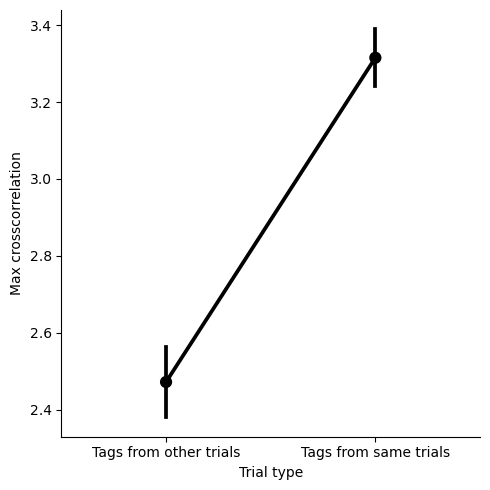

In [121]:
sns.catplot(y='Max crosscorrelation', x='Trial type',  data=crosscorr, kind='point',  color='black')

In [122]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
print(crosscorr)

  participant trial_type     value  Max crosscorrelation  \
0          A0          1  2.563997              2.563997   
1          A0          0  3.241389              3.241389   
2          A2          1  2.380237              2.380237   
3          A2          0  3.388802              3.388802   

               Trial type  
0  Tags from other trials  
1   Tags from same trials  
2  Tags from other trials  
3   Tags from same trials  


In [123]:
md = smf.mixedlm("value ~ trial_type", crosscorr, groups=crosscorr["participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   value 
No. Observations:   4         Method:               REML  
No. Groups:         2         Scale:                0.0139
Min. group size:    2         Log-Likelihood:       0.7465
Max. group size:    2         Converged:            No    
Mean group size:    2.0                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        3.315    0.083 39.799 0.000  3.152  3.478
trial_type[T.1] -0.843    0.118 -7.157 0.000 -1.074 -0.612
Group Var        0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

## 3 Search in subwindows of the tag

In [124]:
from noise_tagging_funs import generate_noise_periods

sfreq = 480 # EEG and tag tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1
tmax_eeg = 2.3

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 45
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq


### 3.1  Timing of the crosscorrelation with the average of the two tags

In [125]:
participants = ['A0', 'A2'] 
summed = []
for participant in participants:
    arr_participant = np.load(f'files/averaged_tags_{participant}.npy')
    summed.append(arr_participant)
summed = np.stack(summed)

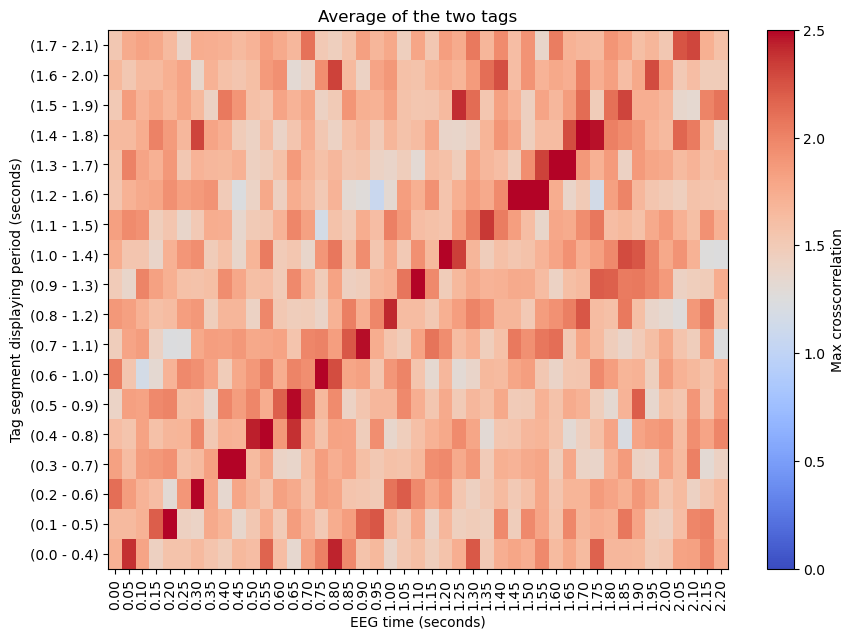

In [126]:
fig, ax = plt.subplots(figsize=(10,7))
avg_summed = summed.mean(axis=0)
cax = ax.imshow(avg_summed, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)

cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax.set_xlabel('EEG time (seconds)')
ax.set_ylabel('Tag segment displaying period (seconds)')
ax.set_title('Average of the two tags')

bin_times = np.linspace(start, end, n_bins)
ax.set_xticks(np.arange(n_bins))
ax.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
ax.set_yticks(np.arange(len(noise_periods)))
ax.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])


plt.show()


In [127]:
idx_noise_periods, idx_bin_times = np.where(summed.mean(axis=0) > 2.65)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f} (zscore = {summed.mean(axis=0)[period, bin]})')

Significant for noise : [1.4 1.8] and bin 1.7 (zscore = 2.684858054051599)
Significant for noise : [1.3 1.7] and bin 1.6 (zscore = 2.6984152223505142)
Significant for noise : [1.3 1.7] and bin 1.6 (zscore = 2.7346233671342652)
Significant for noise : [1.2 1.6] and bin 1.4 (zscore = 2.8145091910870597)
Significant for noise : [1.2 1.6] and bin 1.5 (zscore = 2.7947081409278205)
Significant for noise : [0.4 0.8] and bin 0.5 (zscore = 2.8466276462404165)
Significant for noise : [0.3 0.7] and bin 0.4 (zscore = 2.8153152302392224)
Significant for noise : [0.2 0.6] and bin 0.3 (zscore = 2.9861149113188503)
Significant for noise : [0.1 0.5] and bin 0.2 (zscore = 2.696830966648534)


### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [128]:
participants = ['A0', 'A2'] 
cued, uncued = [], []
for participant in participants:
    arr_participant = np.load(f'files/cued_tags_with_target_{participant}.npy')
    cued.append(arr_participant)
    arr_participant = np.load(f'files/uncued_tags_with_target_{participant}.npy')
    uncued.append(arr_participant)
cued = np.stack(cued)
uncued = np.stack(uncued)

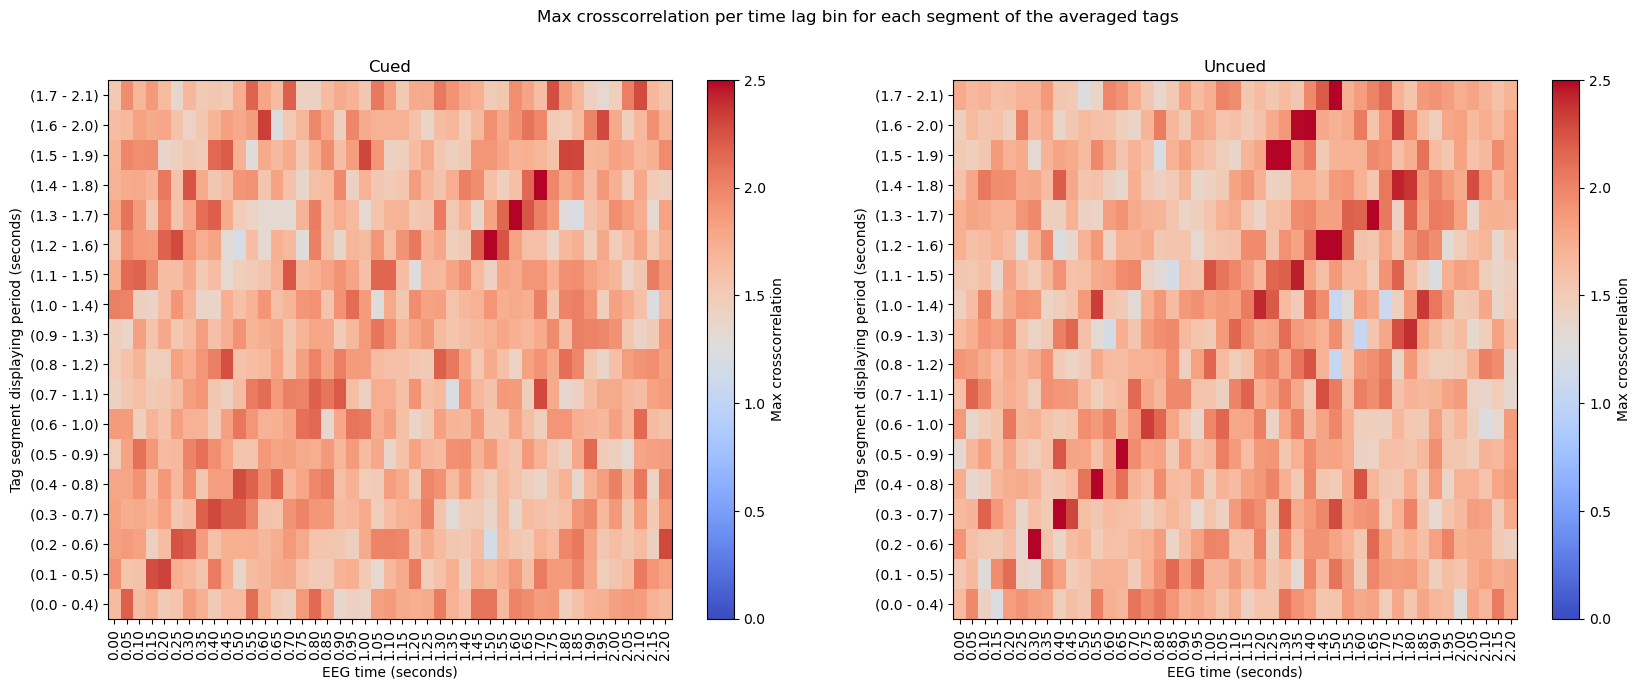

In [129]:
fig, ax = plt.subplots(1,2, figsize=(20,7), sharey=False)
cax = ax[0].imshow(cued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(uncued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=2.5)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

plt.suptitle('Max crosscorrelation per time lag bin for each segment of the averaged tags')

threshold = 1.96
bin_times = np.linspace(start, end, n_bins)
for i, axi in enumerate(ax):
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])
    axi.set_xlabel('EEG time (seconds)')
    axi.set_ylabel('Tag segment displaying period (seconds)')

ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()
plt.show()

In [130]:
idx_noise_periods, idx_bin_times = np.where(cued.mean(axis=0) > 2.65)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Cued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f}  (zscore = {cued.mean(axis=0)[period, bin]})')

[Cued] Significant for noise : [1.4 1.8] and bin 1.7  (zscore = 2.724445605211586)
[Cued] Significant for noise : [1.3 1.7] and bin 1.6  (zscore = 2.8349921960834132)


In [131]:
idx_noise_periods, idx_bin_times = np.where(uncued.mean(axis=0) > 2.65)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Uncued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.1f}  (zscore = {uncued.mean(axis=0)[period, bin]})')

[Uncued] Significant for noise : [1.5 1.9] and bin 1.2  (zscore = 2.7374911255630274)
[Uncued] Significant for noise : [0.5 0.9] and bin 0.6  (zscore = 2.650379789744911)
[Uncued] Significant for noise : [0.4 0.8] and bin 0.5  (zscore = 2.673958755686992)
[Uncued] Significant for noise : [0.3 0.7] and bin 0.4  (zscore = 2.681238253735131)
[Uncued] Significant for noise : [0.2 0.6] and bin 0.3  (zscore = 2.6864900595163315)
